In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
import seaborn as sns
from datetime import datetime
import math
import h5py

In [50]:
path = 'data/gps230125g002.hdf5'

file = h5py.File(path, 'r')

dataset = file['Data'].get('Table Layout') # type: ignore
data_array = np.array(dataset)


dataset1 = file['Data']['Array Layout']['2D Parameters']['tec'] # type: ignore
tec_array = np.array(dataset1)

file.close()

C:\Users\virtanem\AppData\Local\Temp\ipykernel_18096\17028799.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  data_array = np.array(dataset)
C:\Users\virtanem\AppData\Local\Temp\ipykernel_18096\17028799.py:10: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  tec_array = np.array(dataset1)


In [51]:
df = pd.DataFrame(data_array)
df['minute'] = df['min']
df['second'] = df['sec']
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']])
df = df.drop(['recno','kindat','kinst','ut1_unix','ut2_unix', 
'year', 'month', 'day', 'hour', 'minute', 'second', 'min', 'sec'], axis=1)

In [52]:
LAT = [55,80]
LONG = 20

df = df.loc[(df['gdlat'] >= LAT[0]) & (df['gdlat'] <= LAT[1]) & (df['glon'] == LONG)]
df = df.sort_values(by=['gdlat', 'datetime'], ascending=True)
df

,gdlat,glon,tec,dtec,datetime
12639,55.0,20.0,4.855393,0.501022,2023-01-25 00:02:30
28292,55.0,20.0,2.192181,0.753993,2023-01-25 00:07:30
43601,55.0,20.0,1.810041,0.753414,2023-01-25 00:12:30
59165,55.0,20.0,1.726910,0.921351,2023-01-25 00:17:30
105602,55.0,20.0,4.226355,0.921001,2023-01-25 00:32:30
...,...,...,...,...,...
3925517,80.0,20.0,11.755128,0.920653,2023-01-25 21:32:30
4194287,80.0,20.0,14.323078,0.923143,2023-01-25 23:02:30
4208772,80.0,20.0,14.219064,0.921376,2023-01-25 23:07:30
4327483,80.0,20.0,10.659177,1.326802,2023-01-25 23:47:30


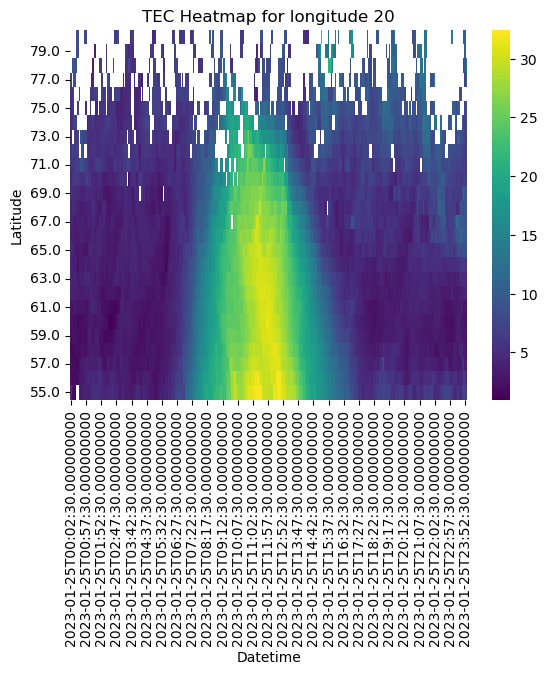

In [53]:
pivot1 = df.pivot(index='gdlat', columns='datetime', values='tec')
sns.heatmap(pivot1, cmap='viridis')

plt.xlabel('Datetime')
plt.ylabel('Latitude')
plt.title(f'TEC Heatmap for longitude {LONG}')
plt.gca().invert_yaxis()

plt.show()

In [54]:
rolling_df = pd.DataFrame()

for lat in df['gdlat'].unique():
    df5 = df.loc[df['gdlat'] == lat]
    moving_avg = df5['tec'].rolling(window=36, min_periods=1, center=True).mean()
    rolling_df = pd.concat([rolling_df, moving_avg], axis=0)

df = pd.concat([df, rolling_df], axis=1)
df['rolling'] = df[0]
df = df.drop(columns=[0])

df['detrended_tec'] = df['tec'] - df['rolling']
df['detrended_tec'].describe()

count    6314.000000
mean        0.004855
std         1.325784
min        -5.445614
25%        -0.753312
50%        -0.069328
75%         0.652915
max        13.122148
Name: detrended_tec, dtype: float64

In [55]:
# path2 = 'data/ruots/gotaland.csv'
path2 = 'data/ruots/norra_norrland.csv'
# path2 = 'data/ruots/sodra_norrland.csv'
# path2 = 'data/ruots/svealand.csv'

dfv = pd.read_csv(path2, header=None, sep=';')

In [56]:
DT1, DT2 = '2023-01-25 00:00:00', '2023-01-26 00:00:00'

dfv['datetime'] = pd.to_datetime(dfv[0])
dfv['i95'] = dfv[1].str.replace(',', '.').astype(float)
dfv.drop([0, 1], axis=1, inplace=True)
dfv = dfv.loc[(dfv['datetime'] >= DT1) & (dfv['datetime'] <= DT2)]

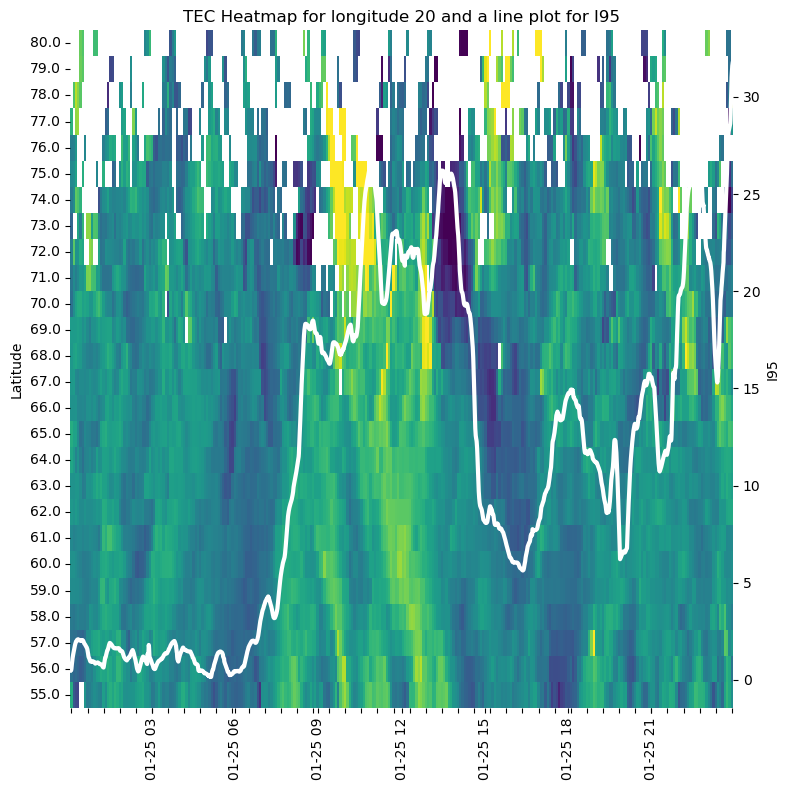

In [57]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

pivot = df.pivot(index='gdlat', columns='datetime', values='detrended_tec')

min_x = df['datetime'].min()
max_x = df['datetime'].max()

ax.set_xlim(min_x, max_x)
g1 = sns.heatmap(pivot, cmap='viridis', vmin=-4, vmax=4, ax=ax, cbar=False)
ax.invert_yaxis()
g1.set(xlabel=None, ylabel = 'Latitude', title = f'TEC Heatmap for longitude {LONG} and a line plot for I95')
ax.set_xticklabels([])


ax2 = fig.add_subplot(111)
ax2.plot(dfv['datetime'], dfv['i95'], color='white', zorder=10, lw=3)
ax2.yaxis.set_label_text('I95')
plt.xticks(rotation =90)
ax2.set_xlim(min_x, max_x)
ax2.yaxis.tick_right()
ax2.grid(False)
ax2.patch.set_alpha(0.0) #type: ignore
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_label_position("right")


plt.tight_layout()

plt.show()